In [12]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from dirichletcal.calib.fulldirichlet import FullDirichletCalibrator
from sklearn.calibration import CalibratedClassifierCV
from sklearn import tree
import CalibrationM as calibm
import warnings
import Uncertainty as unc
import UncertaintyM as uncM

warnings.filterwarnings("ignore")

seed = 1
np.random.seed(seed)
calibration_method = "isotonic"

# Data creation

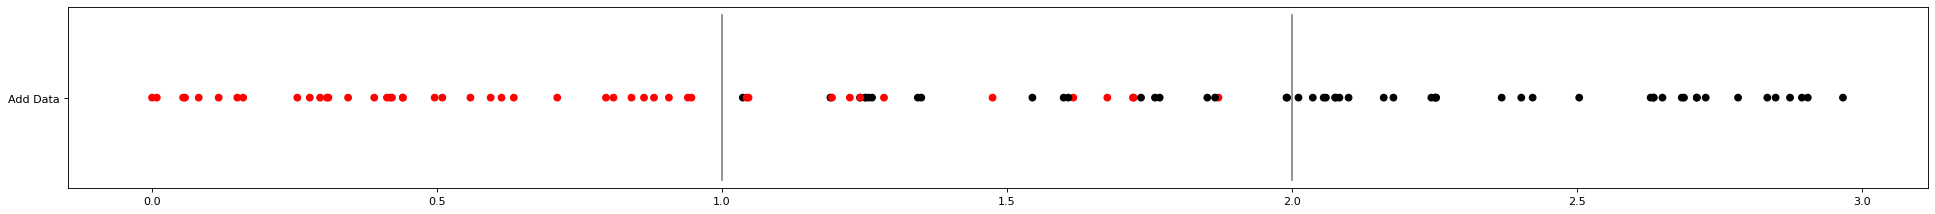

In [3]:

data_size = 100

x = np.random.uniform(low=0, high=3, size=(data_size,))
y = np.where(x<1, 0, np.where(x>2, 1, 1/2))
mid_index = np.argwhere(y==1/2)
mid_index = mid_index.reshape(-1)
rand_y = np.random.binomial(size=len(mid_index), n=1, p= 0.5)
y[mid_index] = rand_y
x = x.reshape(-1,1)

x_train, x_test_all, y_train, y_test_all = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=seed)
x_test, x_calib, y_test, y_calib = train_test_split(x_test_all, y_test_all, test_size=0.5, shuffle=True, random_state=seed) 

figure(figsize=(30, 3), dpi=80)
# plt.plot(x, np.zeros_like(x), "x", color="y")
colors = ['red','black']
plt.scatter(x, np.full(len(x), "Add Data"), c=y, cmap=matplotlib.colors.ListedColormap(colors))
x1, y1 = [1, 1], [1, -1]
x2, y2 = [2, 2], [1, -1]
plt.plot(x1, y1, x2, y2, c="gray")

In [51]:
# optimal prob
from math import nan

def opt_prob(x, threshold_side="left"):
    p_a_0 = 1
    p_b_0 = 1/2
    p_c_0 = 0

    p_a_1 = 0
    p_b_1 = 1/2
    p_c_1 = 1

    # checking the un defined boundaries
    if x < 0: 
        return nan
    if x > 3:
        return nan

    # calculating the length of each section
    if x <= 1:
        a = x
        b = 0
        c = 0    
    if 1 < x <= 2:
        a = 1
        b = x - 1
        c = 0    
    if 2 < x <= 3:
        a = 1
        b = 1
        c = x - 2

    if threshold_side == "right":
        a = 1 - a
        b = 1 - b
        c = 1 - c

        x = 3 - x
    # print("side ", threshold_side)
    # print("a ", a)
    # print("b ", b)
    # print("c ", c)
    prob_1 = (a * p_a_1 + b * p_b_1 + c * p_c_1) / x # Probability of class one on the left side of the threshold ( here threshold is x)
    prob_0 = (a * p_a_0 + b * p_b_0 + c * p_c_0) / x # Probability of class zero on the left side of the threshold

    return prob_0, prob_1

In [52]:
opt_prob(1.5, "right")

(0.16666666666666666, 0.8333333333333334)

In [53]:
opt_prob(1.5, "left")

(0.8333333333333334, 0.16666666666666666)

In [55]:
opt_prob(2, "right")

(0.0, 1.0)

# Model: Decision stump ensembel

In [10]:
model = RandomForestClassifier(max_depth=1, n_estimators=3, random_state=seed)
model.fit(x_train, y_train)
predictions_x_test = model.predict(x_test)
prob_x_test = model.predict_proba(x_test)
prob_x_calib = model.predict_proba(x_calib)

# Member calibration

Tree [0] threshold 1.2514901757240295
Normal          ECE 0.11296296296296299  [0.03703704 1.        ]
calibration iso ECE 0.17500000000000002  [0.21428571 1.        ]
calibration dir ECE 0.17988909058418898  [0.22825454 1.        ]
optimal prob  [0.21404221294150183, 0.8995237115710741]
------------------------------------
Tree [1] threshold 1.6921833753585815
Normal          ECE 0.15000000000000002  [0.         0.90322581]
calibration iso ECE 0.23888888888888893  [0.22222222 0.63636364]
calibration dir ECE 0.15  [1.47238342e-104 7.34749795e-001]
optimal prob  [0.11768340409566846, 0.7954762511445]
------------------------------------
Tree [2] threshold 1.7407686710357666
Normal          ECE 0.10357142857142856  [0.         0.92857143]
calibration iso ECE 0.19780219780219782  [0.14285714 0.61538462]
calibration dir ECE 0.11173947009209748  [1.47238342e-104 7.65210598e-001]
optimal prob  [0.10293236953430207, 0.7872294339387998]
------------------------------------


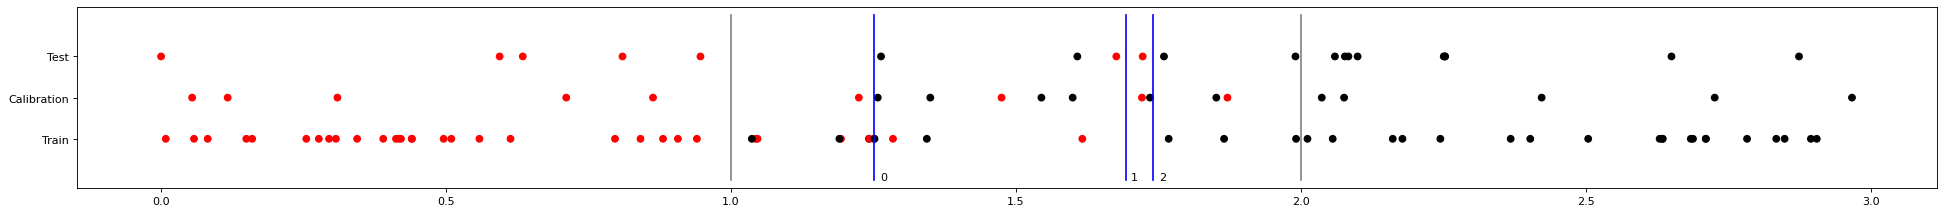

In [5]:
figure(figsize=(30, 3), dpi=80)

for est_index, estimator in enumerate(model.estimators_):
    # tree.plot_tree(estimator)
    tree_threshold = estimator.tree_.threshold[0]
    tree_prob_x_test = estimator.predict_proba(x_test)

    # print(tree_prob_x_test)
    
    print(f"Tree [{est_index}] threshold {tree_threshold}")
    print(f"Normal          ECE {calibm.confidance_ECE(tree_prob_x_test, y_test)} ", np.unique(tree_prob_x_test[:,0]))

    # Full Dirichlet
    if calibration_method == "isotonic":
        model_calib = CalibratedClassifierCV(estimator, cv="prefit", method=calibration_method) # cv=30
        model_calib.fit(x_calib , y_calib)
        tree_prob_x_test_calib = model_calib.predict_proba(x_test)

        print(f"calibration iso ECE {calibm.confidance_ECE(tree_prob_x_test_calib, y_test)} ", np.unique(tree_prob_x_test_calib[:,0]))

    if calibration_method == "Dir":
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
        reg = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        calibrator = FullDirichletCalibrator(reg_lambda=reg, reg_mu=None)
        dir_calib = GridSearchCV(calibrator, param_grid={'reg_lambda':  reg, 'reg_mu': [None]}, cv=skf, scoring='neg_log_loss')
        dir_calib.fit(prob_x_calib , y_calib)
        tree_prob_x_test_calib = dir_calib.predict_proba(tree_prob_x_test)
        
        print(f"calibration dir ECE {calibm.confidance_ECE(tree_prob_x_test_calib, y_test)} ", np.unique(tree_prob_x_test_calib[:,0]))

    # optimal prob
    a = 1
    b = tree_threshold - 1
    c = 2 - tree_threshold
    o_p_neg = a/(a+b) + (b * (1/2)) /(a+b)
    o_p_pos = a/(a+c) + (c * (1/2)) /(a+c)
    # o_p_pos = (c * (1/2))
    print(f"optimal prob ", [1 - o_p_pos, o_p_neg])
    print("------------------------------------")

    plt.plot([tree_threshold,tree_threshold], [3,-1], c="blue")
    plt.annotate(est_index, (tree_threshold+0.01, -1))

plt.scatter(x_train, np.full(len(x_train), "Train"), c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
# for i, txt in enumerate(np.ones(len(x_train))): # attempt to label the training data of each tree in the RF (plot works but cannot access the training subsets)
#     plt.annotate(int(txt), (x_train[i], "Train"))

plt.scatter(x_calib, np.full(len(x_calib), "Calibration"), c=y_calib, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(x_test, np.full(len(x_test), "Test"), c=y_test, cmap=matplotlib.colors.ListedColormap(colors))
x1, y1 = [1, 1], [3, -1]
x2, y2 = [2, 2], [3, -1]
plt.plot(x1, y1, x2, y2, c="gray")

# Ens Calibration

In [6]:
print(f"Normal          ECE {calibm.confidance_ECE(prob_x_test, y_test)} {np.unique(prob_x_test[:,0])}")

if calibration_method == "isotonic":
    model_calib = CalibratedClassifierCV(model, cv="prefit", method=calibration_method) # cv=30
    model_calib.fit(x_calib , y_calib)
    prob_x_test_calib = model_calib.predict_proba(x_test)

    print(f"calibration iso ECE {calibm.confidance_ECE(prob_x_test_calib, y_test)} ", np.unique(prob_x_test_calib[:,0]))

# Full Dirichlet
if calibration_method == "Dir":
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    reg = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    calibrator = FullDirichletCalibrator(reg_lambda=reg, reg_mu=None)
    dir_calib = GridSearchCV(calibrator, param_grid={'reg_lambda':  reg, 'reg_mu': [None]}, cv=skf, scoring='neg_log_loss')
    dir_calib.fit(prob_x_calib , y_calib)
    prob_x_test_calib = dir_calib.predict_proba(prob_x_test)

    print(f"calibration dir ECE {calibm.confidance_ECE(prob_x_test_calib, y_test)} ", np.unique(prob_x_test_calib[:,0]))


Normal          ECE 0.09815525971439953 [0.01234568 0.32186949 0.62294476 0.94393241]
calibration iso ECE 0.12142857142857146  [0.14285714 0.28571429 1.        ]
calibration dir ECE 0.2070317889815329  [0.16776431 0.42266516 0.55159835 0.7873803 ]


# ECE calculation

In [7]:
normal_cw_ece = calibm.classwise_ECE(prob_x_test, y_test)
normal_conf_ece = calibm.confidance_ECE(prob_x_test, y_test)

print(normal_cw_ece)
print(normal_conf_ece)

[0.09131393298059962, 0.0913139329805997]
0.09815525971439953


# Uncertainty

In [8]:
# unc Q id
tu, eu, au = unc.model_uncertainty(model, x_test, x_train, y_train)
tumc, eumc, aumc, porb_matrix = unc.calib_ens_member_uncertainty(model, x_test, y_test, x_train, y_train, x_calib, y_calib, calibration_method, seed)
tuc = unc.calib_ens_total_uncertainty(prob_x_test_calib)

array([0.28329076, 0.38982999, 0.28329076, 0.38982999, 0.28329076,
       0.38982999, 0.28329076, 0.38982999, 0.28329076, 0.28329076,
       0.38982999, 0.44629561, 0.28329076, 0.28329076, 0.44629561,
       0.28329076, 0.44629561, 0.28329076, 0.3347869 , 0.28329076])

In [14]:
uncM.unc_auroc(predictions_x_test, y_test, au)

0.8627450980392156

In [15]:
uncM.unc_auroc(predictions_x_test, y_test, aumc)

0.9607843137254902